<a href="https://colab.research.google.com/github/Ramesh6797/Twitter-Climate-Change-Sentiment-Analysis/blob/main/Twitter_Climate_Change_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Packages and Data

In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "twitter_sentiment_data.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "edqian/twitter-climate-change-sentiment-dataset",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)


/tmp/ipython-input-3832636858.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'twitter-climate-change-sentiment-dataset' dataset.


In [ ]:
#loading the data from csv file to pandas dataframe
import pandas as pd

DATA_PATH = "/kaggle/input/twitter-climate-change-sentiment-dataset/twitter_sentiment_data.csv"
twitter_data = pd.read_csv(DATA_PATH)


In [ ]:
pip install pydataset

In [ ]:
# import packages
import pandas as pd
import numpy as np
from os import makedirs
from os import path
import math
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import nltk.downloader
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.util import ngrams

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from pydataset import data
from sklearn.ensemble        import BaggingClassifier, \
         ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import RidgeClassifier
from sklearn.svm             import SVC
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

import pickle
import json

In [ ]:
# set up label dataframe for future refrences

label = [-1, 0, 1, 2]
labelN = ["Anti", "Neutral", "Pro", "News"]
labelDesc = [
    "the tweet does not believe in man-made climate change"
    , "the tweet neither supports nor refutes the belief of man-made climate change"
    , "the tweet supports the belief of man-made climate change"
    , "the tweet links to factual news about climate change"
]

labelDf = pd.DataFrame(list(zip(label, labelN, labelDesc)), columns=["label", "name", "description"])

Data Dictionary

In [ ]:
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the p...,792927353886371840
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world...",793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of cl...",793125156185137153


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  43943 non-null  int64 
 1   message    43943 non-null  object
 2   tweetid    43943 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


Distribution of Sentiments


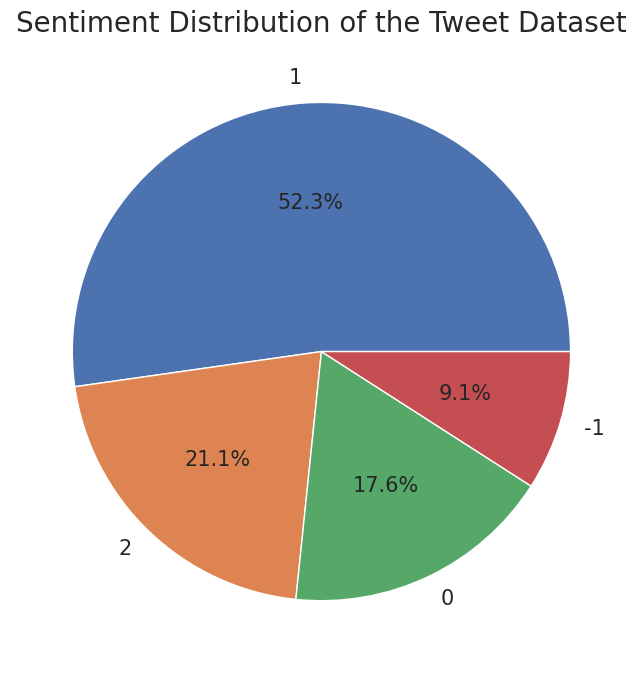

In [ ]:
plt.figure(figsize = (7, 7))
plt.pie(df.sentiment.value_counts().values, labels = df.sentiment.value_counts().index, autopct = '%2.1f%%', textprops={'fontsize': 15})
plt.title('Sentiment Distribution of the Tweet Dataset', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
df.sentiment.value_counts()

,count
sentiment,
1,22962
2,9276
0,7715
-1,3990


Data Preparation for Sentiment Analysis

(Tweet texts will be transformed and vectorized to be fed into models.)

In [ ]:
# separate the messages column for transformation.
dfTweets = df["message"]

Tokenization

All the tweets are first split into arrays of words.

In [ ]:
def createTokenizedArray(sentences):
    '''
    Create lower case array of words with no punctuation.
    :param sentences: array or series of texts
    :return: lower case array of words with no punctuation.
    '''
    # Initialize tokenizer and empty array to store modified sentences.
    tokenizer = RegexpTokenizer(r'\w+') #Regular Expression Tokenizer that splits text into words, keeping only letters/numbers/underscores, and removing punctuation
    tokenizedArray = []
    for i in range(0, len(sentences)):
        # Convert sentence to lower case.
        sentence = sentences[i].lower()

        # Split sentence into array of words with no punctuation.
        words = tokenizer.tokenize(sentence)

        # Append word array to list.
        tokenizedArray.append(words)

    # print(tokenizedArray)
    return tokenizedArray  # send modified contents back to calling function.

In [ ]:
tokenizedLi = createTokenizedArray(dfTweets)

pd.Series(tokenizedLi[:5])

,0
0,"[tiniebeany, climate, change, is, an, interesting, hustle, as, it, was, global, warmin..."
1,"[rt, natgeochannel, watch, beforetheflood, right, here, as, leodicaprio, travels, the,..."
2,"[fabulous, leonardo, dicaprio, s, film, on, climate, change, is, brilliant, do, watch,..."
3,"[rt, mick_fanning, just, watched, this, amazing, documentary, by, leonardodicaprio, on..."
4,"[rt, cnalive, pranita, biswasi, a, lutheran, from, odisha, gives, testimony, on, effec..."


Stop Word Removal

Stop words are the words that do not add any significant values to the query search, such as "the", "a", and "an". They are safe to be removed from the tokenized list. And also ignore single character words and digits.

In [ ]:
# To get stop words.
nltk.download('stopwords')

def removeStopWords(tokenList):
    '''
    Create array of words with no punctuation or stop words.
    :param tokenList: tokenized list
    :return: array of words with no punctuation or stop words.
    '''
    stopWords = set(stopwords.words('english')) # EX of stopwords ['i', 'me', 'my', 'we', 'our', 'you', 'he', 'she', 'it', 'the', 'is', 'and', 'but']
    shorterSentences = []  # Declare empty array of sentences.

    for sentence in tokenList:
        shorterSentence = []  # Declare empty array of words in single sentence.
        for word in sentence:
            if word not in stopWords:

                # Remove leading and trailing spaces.
                word = word.strip()

                # Ignore single character words and digits.
                if (len(word) > 1 and word.isdigit() == False):
                    # Add remaining words to list.
                    shorterSentence.append(word)
        shorterSentences.append(shorterSentence)
    return shorterSentences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
tokenizedNoStopLi = removeStopWords(tokenizedLi)

print(f"Sample sentence BEFORE removing stop words:\n{tokenizedLi[0]}")
print(f"\n\nSample sentence AFTER removing stop words:\n{tokenizedNoStopLi[0]}")

Sample sentence BEFORE removing stop words:
['tiniebeany', 'climate', 'change', 'is', 'an', 'interesting', 'hustle', 'as', 'it', 'was', 'global', 'warming', 'but', 'the', 'planet', 'stopped', 'warming', 'for', '15', 'yes', 'while', 'the', 'suv', 'boom']


Sample sentence AFTER removing stop words:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']


***Stemming***

English words are often time variations of a root word. Stemming rebuilds sentences by removing suffixes from words. It potentially improves the sentiment algorithm by accepting different words as one word as long as they were originated from the same stem.

In [ ]:
def stemWords(sentenceArrays):
    '''
    Removes suffixes and rebuilds the sentences.
    :param sentenceArrays: stentences list
    :return: array of sentences without suffixes
    '''
    ps = PorterStemmer()
    stemmedSentences = []
    for sentenceArray in sentenceArrays:
        stemmedArray = []  # Declare empty array of words.
        for word in sentenceArray:
            stemmedArray.append(ps.stem(word))  # Add stemmed word.

        # Convert array back to sentence of stemmed words.
        delimeter = ' '
        sentence = delimeter.join(stemmedArray)

        # Append stemmed sentence to list of sentences.
        stemmedSentences.append(sentence)
    return stemmedSentences

In [ ]:
stemmedLi = stemWords(tokenizedNoStopLi)

print(f"Sample sentence BEFORE stemming:\n{tokenizedNoStopLi[0]}")
print(f"\nSample sentence AFTER stemming:\n{stemmedLi[0]}")

Sample sentence BEFORE stemming:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']

Sample sentence AFTER stemming:
tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom


Vectorization

Now the stemmed sentences will be vectorized. It essentially transforms all the existing words into numbers so they can be fed to various big data algorithms.

In [ ]:
def vectorizeList(stemmedList, ngramRangeStart, ngramRangeEnd):
    '''
    Creates a matrix of word vectors.
    :param stemmedList: stemmed sentence list
    :return: matrix of word vectors and vocabulary dictionary
    '''
    cv = CountVectorizer(binary=True, ngram_range=(ngramRangeStart, ngramRangeEnd))
    cv.fit(stemmedList)
    X = cv.transform(stemmedList)

    return X, cv.vocabulary_

In [ ]:
vectorizedTweets, vectorDictionary = vectorizeList(stemmedLi, 1, 1)

Let's look into 2 different sample sentences to understand better what vectorization does

In [ ]:
print(f"Sample sentence #1:\n{stemmedLi[0]}")
print(f"Sample sentence #2:\n{stemmedLi[1]}")

Sample sentence #1:
tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom
Sample sentence #2:
rt natgeochannel watch beforetheflood right leodicaprio travel world tackl climat chang http co lkdehj3tnn httã


In [ ]:
print(f"\n#1 after vectorization:\n{vectorizedTweets[0]}")
print(f"#2 after vectorization:\n{vectorizedTweets[1]}")


#1 after vectorization:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 12 stored elements and shape (1, 67195)>
  Coords	Values
  (0, 10652)	1
  (0, 12943)	1
  (0, 13774)	1
  (0, 24524)	1
  (0, 27759)	1
  (0, 29419)	1
  (0, 45475)	1
  (0, 54598)	1
  (0, 55193)	1
  (0, 57219)	1
  (0, 61855)	1
  (0, 64839)	1
#2 after vectorization:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 15 stored elements and shape (1, 67195)>
  Coords	Values
  (0, 9419)	1
  (0, 12943)	1
  (0, 13774)	1
  (0, 14222)	1
  (0, 27583)	1
  (0, 27591)	1
  (0, 35060)	1
  (0, 35653)	1
  (0, 40355)	1
  (0, 49581)	1
  (0, 50386)	1
  (0, 55654)	1
  (0, 57882)	1
  (0, 61927)	1
  (0, 63129)	1


In [ ]:
vectorizedTweets.shape

(43943, 67195)

Bi-Grams

Using N-Grams, we can group N numbers of words together and analyze their frequencies for specific sentiment rating.

In [ ]:
def generateWordList(wordDf, sentimentScore, n_gram_size):
    resultDf = wordDf[(wordDf['sentiment'] == sentimentScore)]

    sentences = [sentence.split() for sentence in resultDf['transformedTweets']]
    wordArray = []
    for i in range(0, len(sentences)):
        wordArray += sentences[i]

    counterList = Counter(ngrams(wordArray, n_gram_size)).most_common(80)

    counterDf = pd.DataFrame()

    delimiter = ' '
    print(f"\n***N-Gram (Sentiment: {sentimentScore})")
    for i in range(0, len(counterList)):
        counterDict = {
            "N-Gram" : delimiter.join(counterList[i][0])
            ,"Occurrences" : counterList[i][1]
        }
        # convert dict to series before concating to the dataframe.
        counterDict = pd.DataFrame(counterDict, index=[0])
        counterDf = pd.concat([counterDf, counterDict], ignore_index=True)

    return counterDf

In [ ]:
# N-Gram variables
SIZE = 2
# add transformedTweets column to the original dataset with the stemmed data.
df['transformedTweets'] = stemmedLi
dfSub = df[['sentiment', 'transformedTweets']]


***N-Gram (Sentiment: -1)
                N-Gram  Occurrences
0         climat chang         2211
1              http co         1873
2          global warm         1855
3             man made          174
4           chang http          150
5     rt stevesgoddard          118
6            warm http          114
7              al gore          103
8              http rt           91
9   rt realdonaldtrump           87
10         made climat           86
11         made global           73
12             warm rt           72
13            chang rt           66
14          chang real           65
15         warm climat           61
16           warm hoax           60
17       believ climat           54
18          chang hoax           53
19         caus global           48


/tmp/ipython-input-2749318923.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

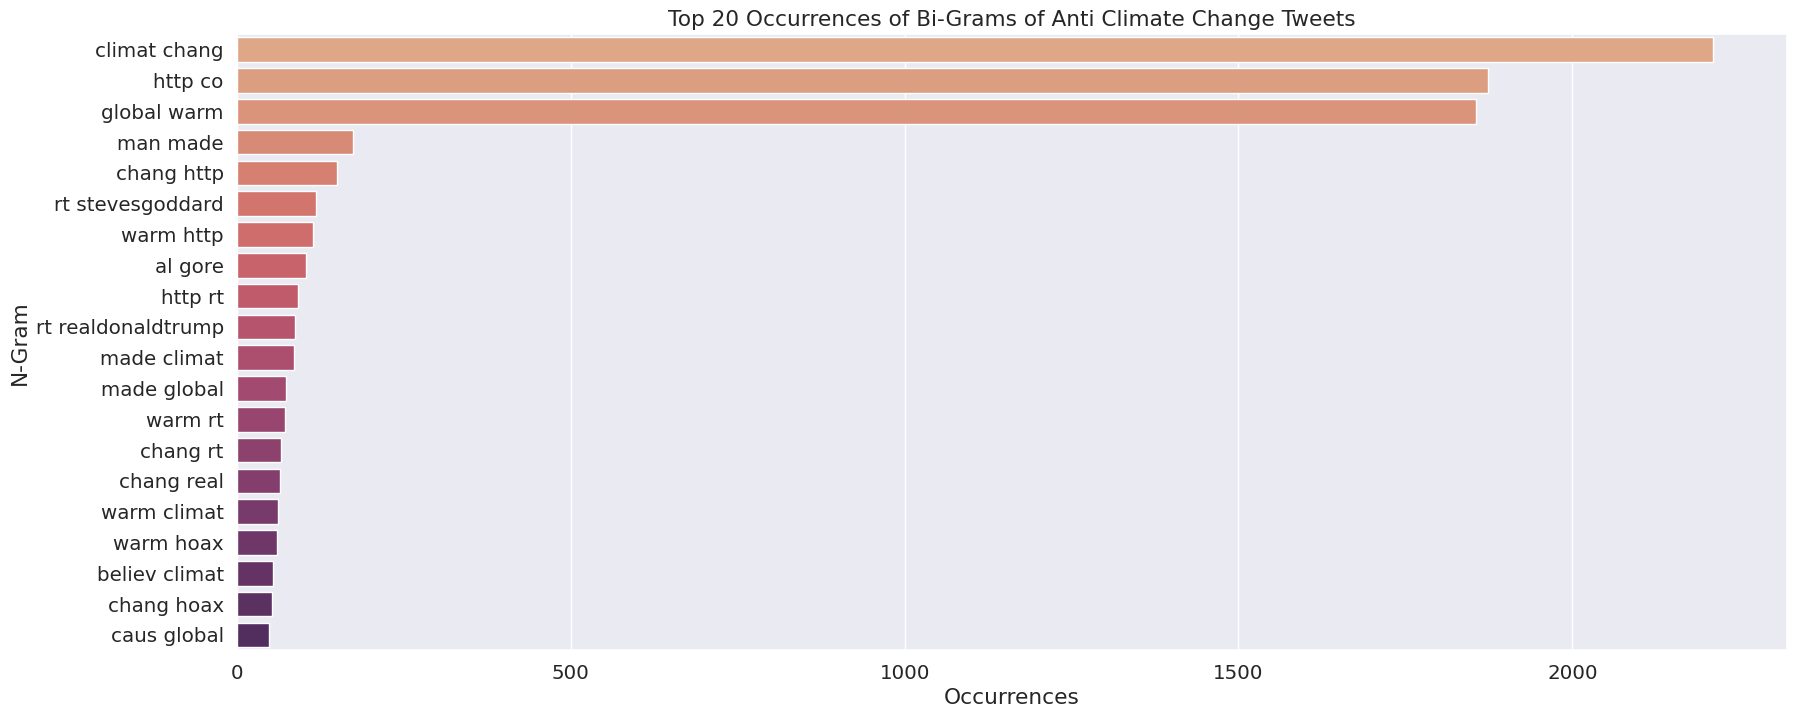

In [ ]:
counterDfAntiTop = generateWordList(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")


***N-Gram (Sentiment: 0)
           N-Gram  Occurrences
0    climat chang         4491
1         http co         3271
2     global warm         3109
3      chang http          447
4       warm http          289
5         warm rt          236
6        chang rt          218
7     caus global          137
8       warm real          121
9         http rt          109
10  believ climat          107
11    talk climat           99
12          ðÿ ðÿ           88
13   think global           82
14   club penguin           82
15     chang real           81
16  believ global           75
17    caus climat           70
18   penguin shut           68
19     chang hoax           63


/tmp/ipython-input-2684317223.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25")


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

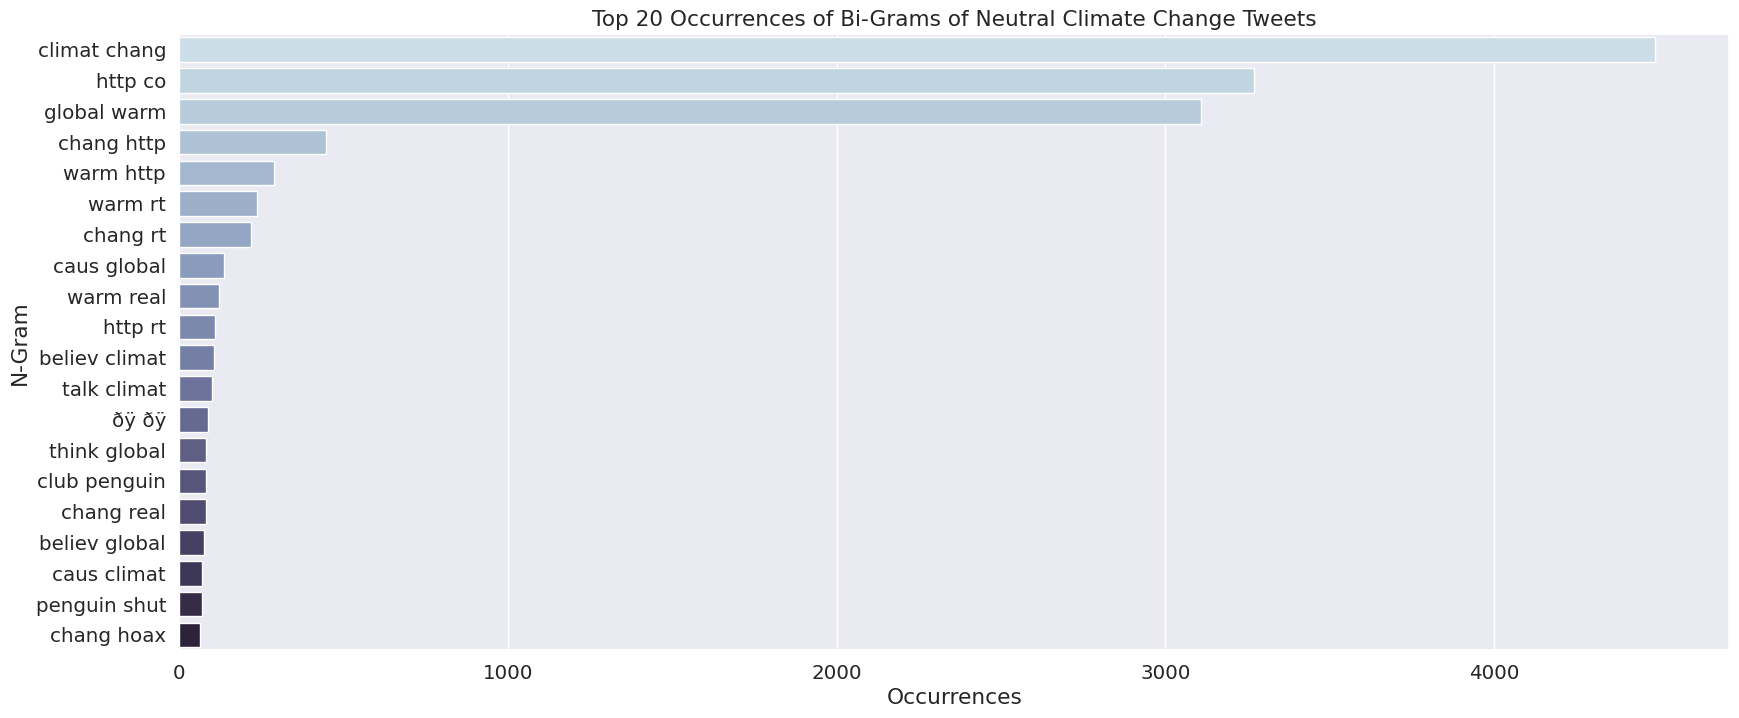

In [ ]:
counterDfNeutral = generateWordList(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutral.head(20)
print(counterDfNeutralTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25")


***N-Gram (Sentiment: 1)
                   N-Gram  Occurrences
0            climat chang        19124
1                 http co        12378
2             global warm         3851
3              chang http         2799
4           believ climat         1427
5            fight climat          836
6                 http rt          788
7            chang denier          711
8              chang real          679
9                  go die          540
10               think go          514
11         husband believ          512
12            die husband          510
13     rt stephenschlegel          507
14  stephenschlegel think          507
15             co sjofonã          506
16              warm http          494
17               chang rt          477
18            deni climat          448
19             sjofonã rt          435


/tmp/ipython-input-3457609949.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.1,l=0.8")


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

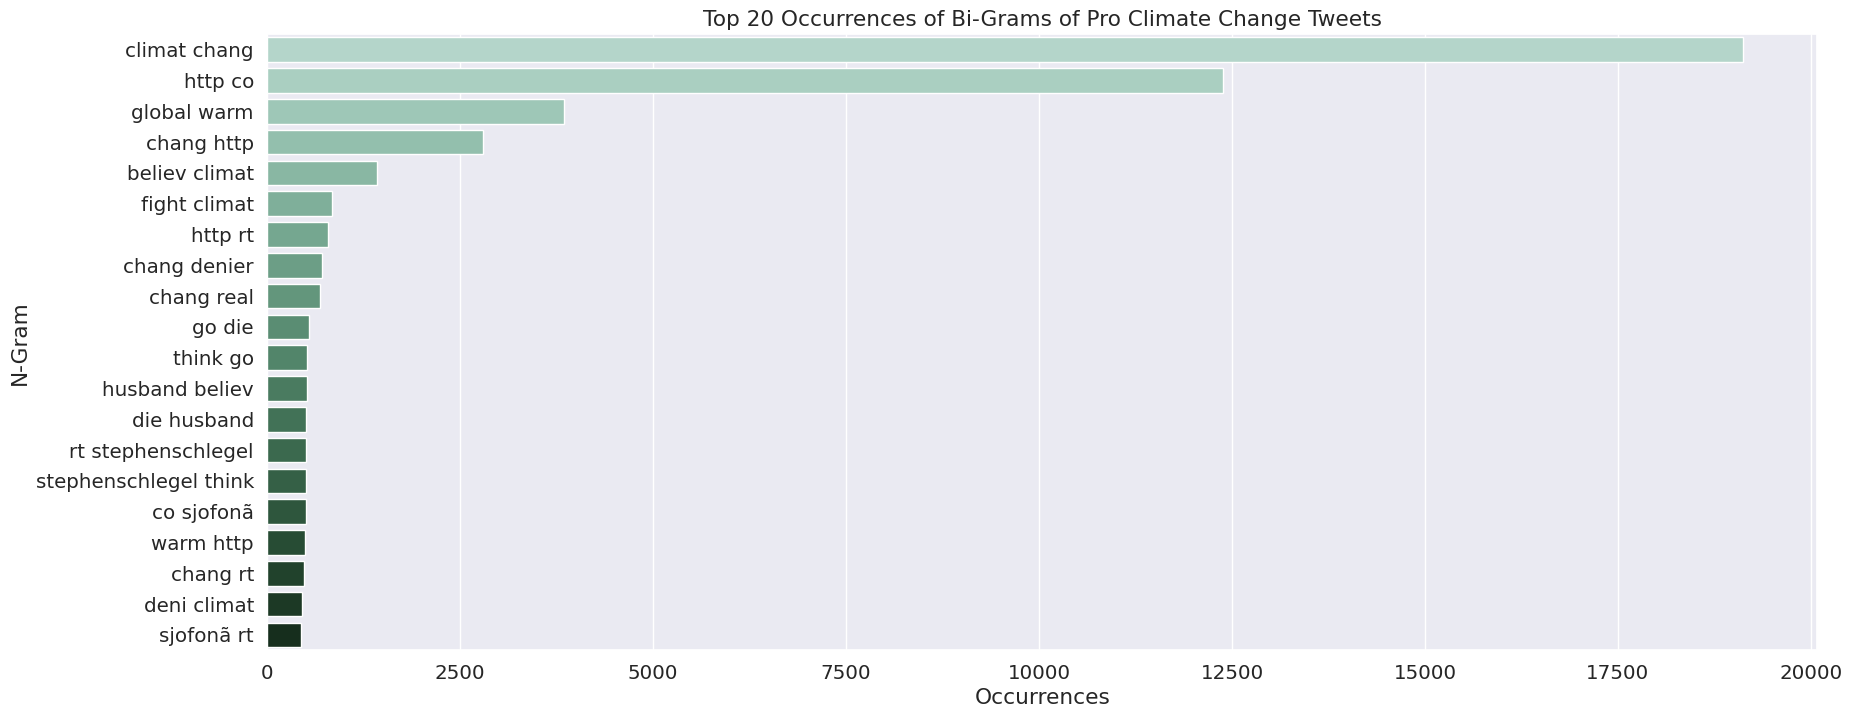

In [ ]:
counterDfPro = generateWordList(dfSub, 1, SIZE)
counterDfProTop = counterDfPro.head(20)
print(counterDfProTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.1,l=0.8")


***N-Gram (Sentiment: 2)
          N-Gram  Occurrences
0        http co        10199
1   climat chang         8102
2     chang http         2000
3    global warm         1196
4   fight climat          356
5      warm http          350
6   donald trump          269
7   trump climat          248
8        http rt          244
9   scott pruitt          218
10     rt thehil          208
11     epa chief          150
12   pari climat          129
13  tackl climat          126
14    say climat          126
15         co rt          126
16      say http          126
17    due climat          122
18     news http          121
19  chang polici          118


/tmp/ipython-input-3288438905.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNewsTop, palette="ch:2.8, r=.1")


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of News Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

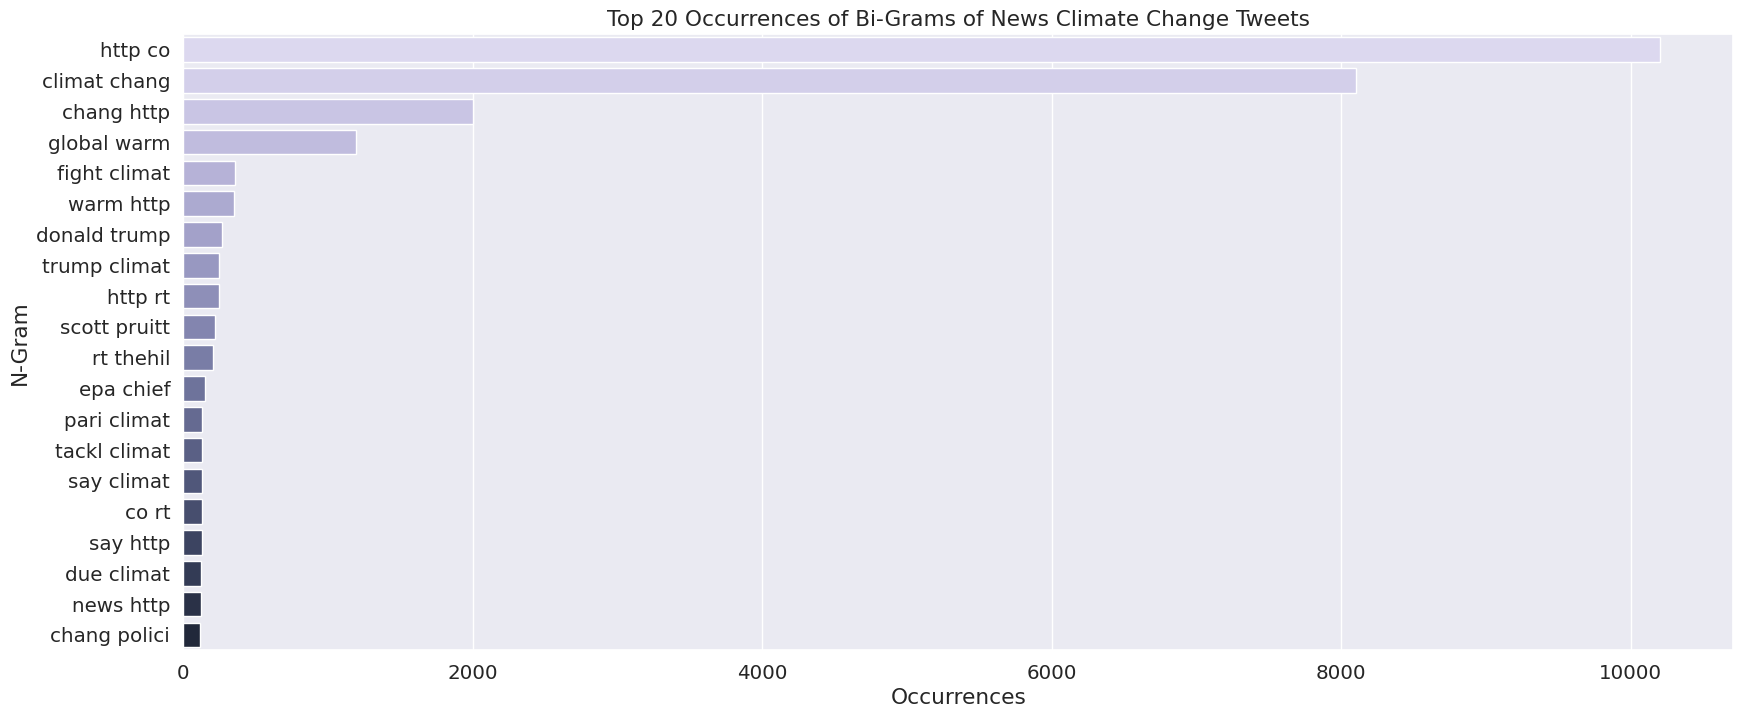

In [ ]:
counterDfNews = generateWordList(dfSub, 2, SIZE)
counterDfNewsTop = counterDfNews.head(20)
print(counterDfNewsTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Bi-Grams of News Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNewsTop, palette="ch:2.8, r=.1")

In [ ]:
SIZE = 3


***N-Gram (Sentiment: -1)
                 N-Gram  Occurrences
0     climat chang http          146
1         chang http co          138
2      global warm http          112
3          warm http co          105
4     made climat chang           82
5       man made climat           78
6        global warm rt           71
7      made global warm           71
8       man made global           67
9     climat chang real           65
10      climat chang rt           61
11     global warm hoax           60
12   global warm climat           59
13    climat chang hoax           52
14  believ climat chang           52
15    warm climat chang           50
16     global warm data           45
17    caus climat chang           44
18     caus global warm           44
19    global warm creat           43


/tmp/ipython-input-232955823.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

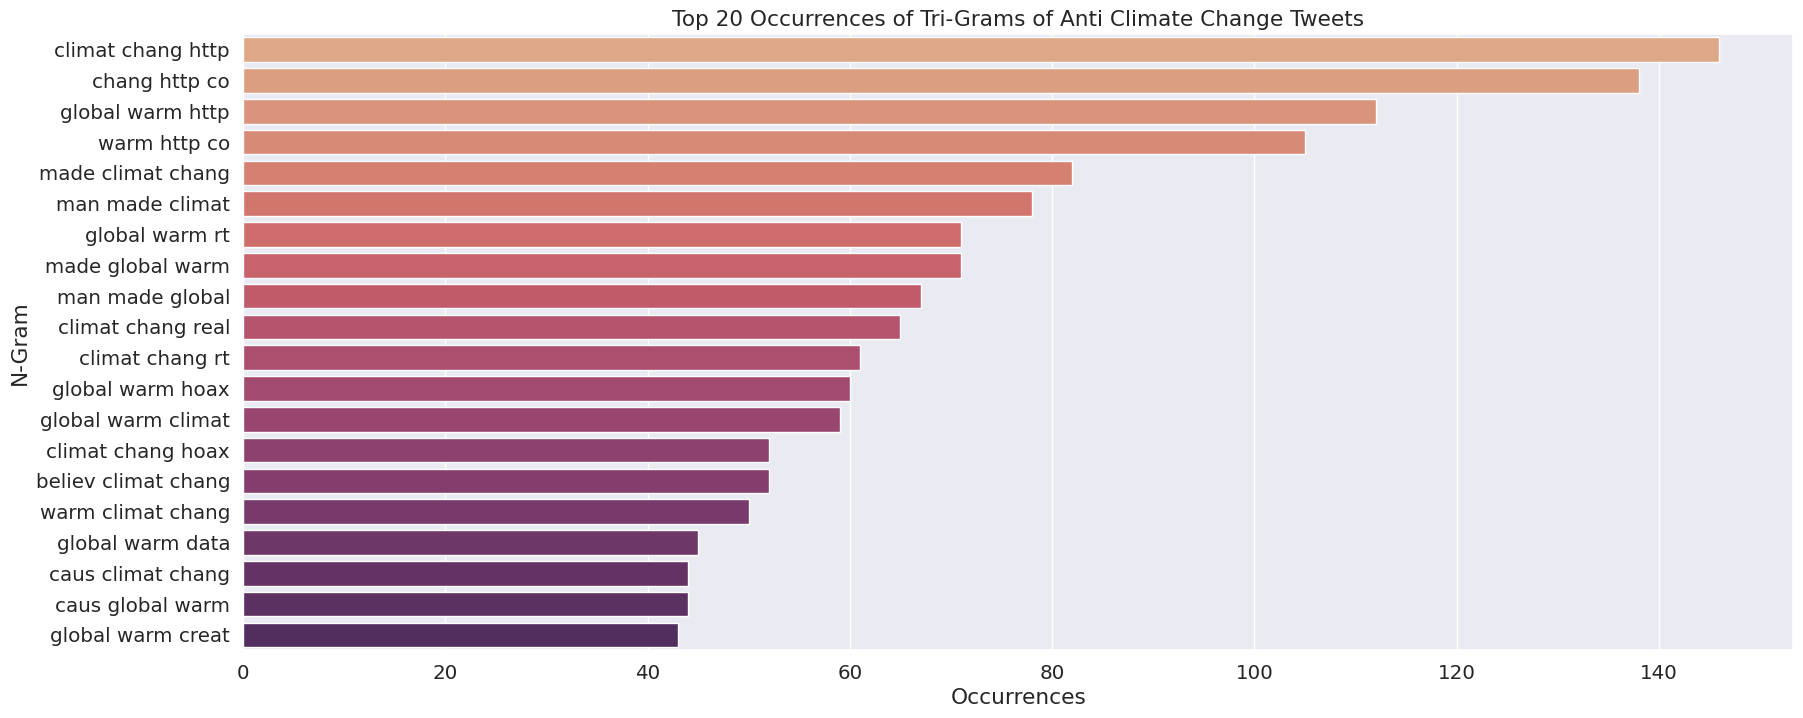

In [ ]:
counterDfAntiTop = generateWordList(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")


***N-Gram (Sentiment: 0)
                 N-Gram  Occurrences
0     climat chang http          444
1         chang http co          424
2      global warm http          289
3          warm http co          280
4        global warm rt          235
5       climat chang rt          214
6      caus global warm          137
7      global warm real          121
8   believ climat chang          106
9     talk climat chang           96
10    think global warm           81
11    climat chang real           81
12   believ global warm           74
13    caus climat chang           69
14    club penguin shut           68
15    climat chang hoax           63
16   think climat chang           58
17     stop global warm           57
18   fight climat chang           56
19     say climat chang           52


/tmp/ipython-input-3158933535.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25")


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

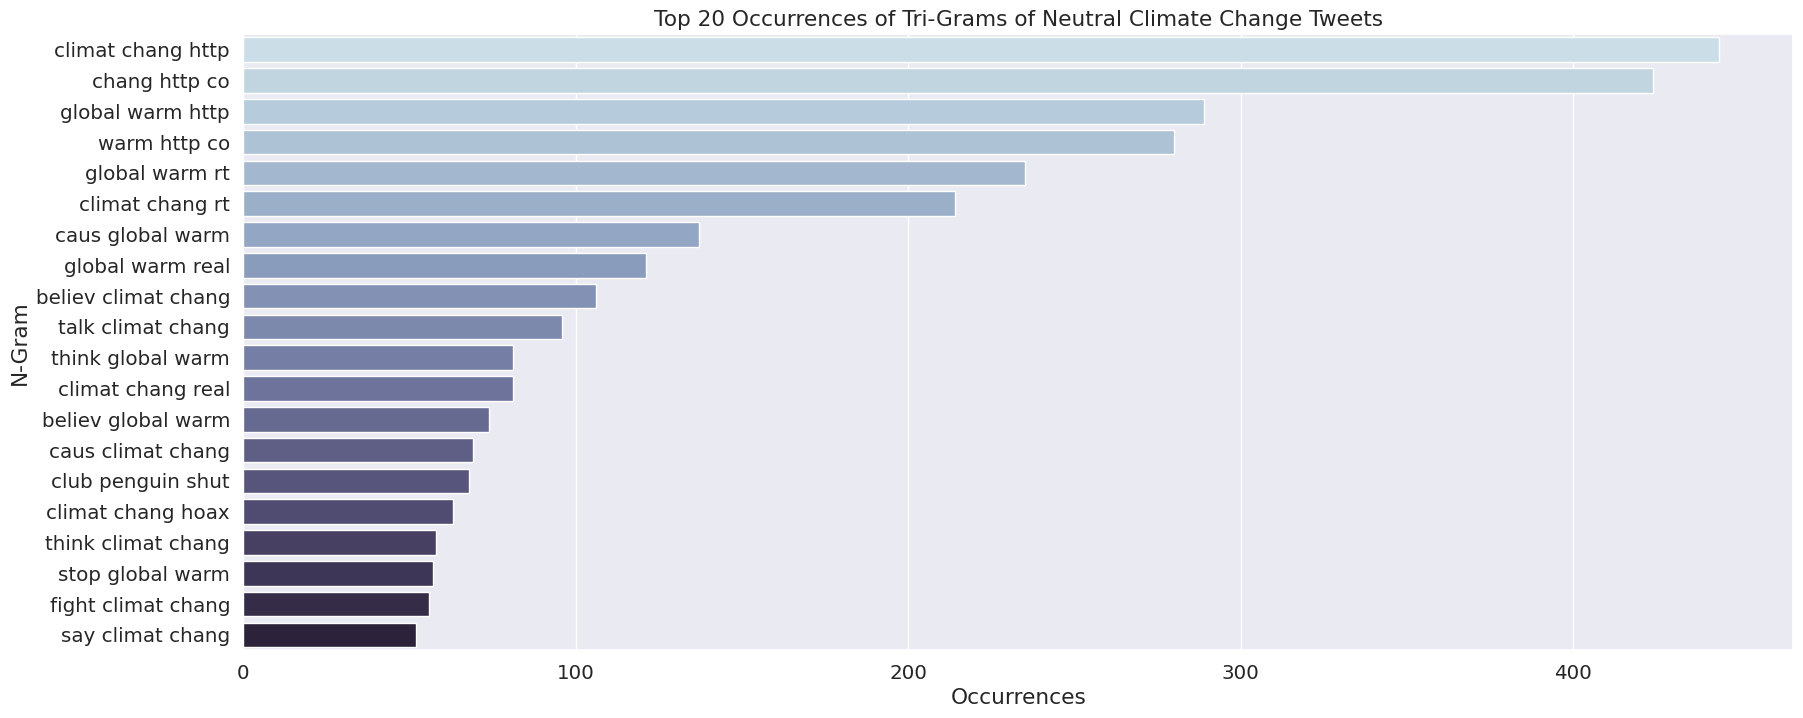

In [ ]:
counterDfNeutral = generateWordList(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutral.head(20)
print(counterDfNeutralTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25")


***N-Gram (Sentiment: 1)
                      N-Gram  Occurrences
0          climat chang http         2787
1              chang http co         2635
2        believ climat chang         1422
3         fight climat chang          822
4        climat chang denier          711
5          climat chang real          679
6      husband believ climat          512
7               think go die          510
8             go die husband          510
9         die husband believ          510
10  rt stephenschlegel think          507
11  stephenschlegel think go          507
12           http co sjofonã          506
13          global warm http          480
14              warm http co          470
15           climat chang rt          465
16             co sjofonã rt          435
17         deni climat chang          428
18        tackl climat chang          385
19       combat climat chang          366


/tmp/ipython-input-1437867144.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.2,l=.6")


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

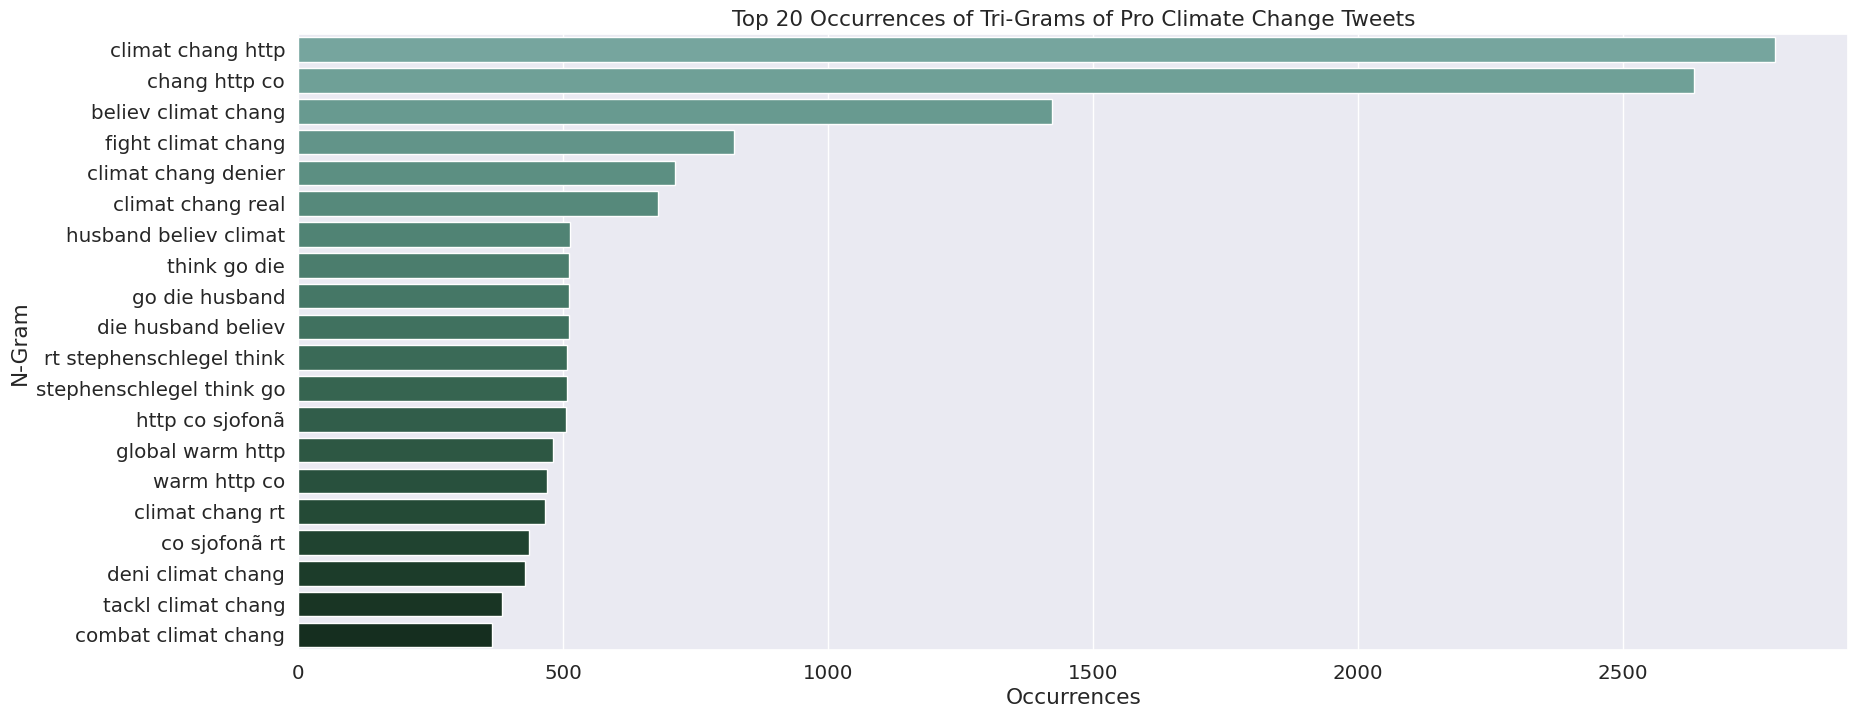

In [ ]:
counterDfPro = generateWordList(dfSub, 1, SIZE)
counterDfProTop = counterDfPro.head(20)
print(counterDfProTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.2,l=.6")


***N-Gram (Sentiment: 2)
                    N-Gram  Occurrences
0        climat chang http         1998
1            chang http co         1964
2       fight climat chang          355
3         global warm http          348
4             warm http co          346
5       trump climat chang          244
6               http co rt          126
7       tackl climat chang          125
8         say climat chang          124
9         due climat chang          122
10            news http co          121
11             say http co          121
12       pari climat chang          117
13     climat chang polici          116
14     action climat chang           96
15     effect climat chang           88
16      climat chang could           82
17           studi http co           81
18  climat chang agreement           80
19       talk climat chang           79


/tmp/ipython-input-1411884589.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNewsTop, palette="light:#D7AF60")


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of News Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

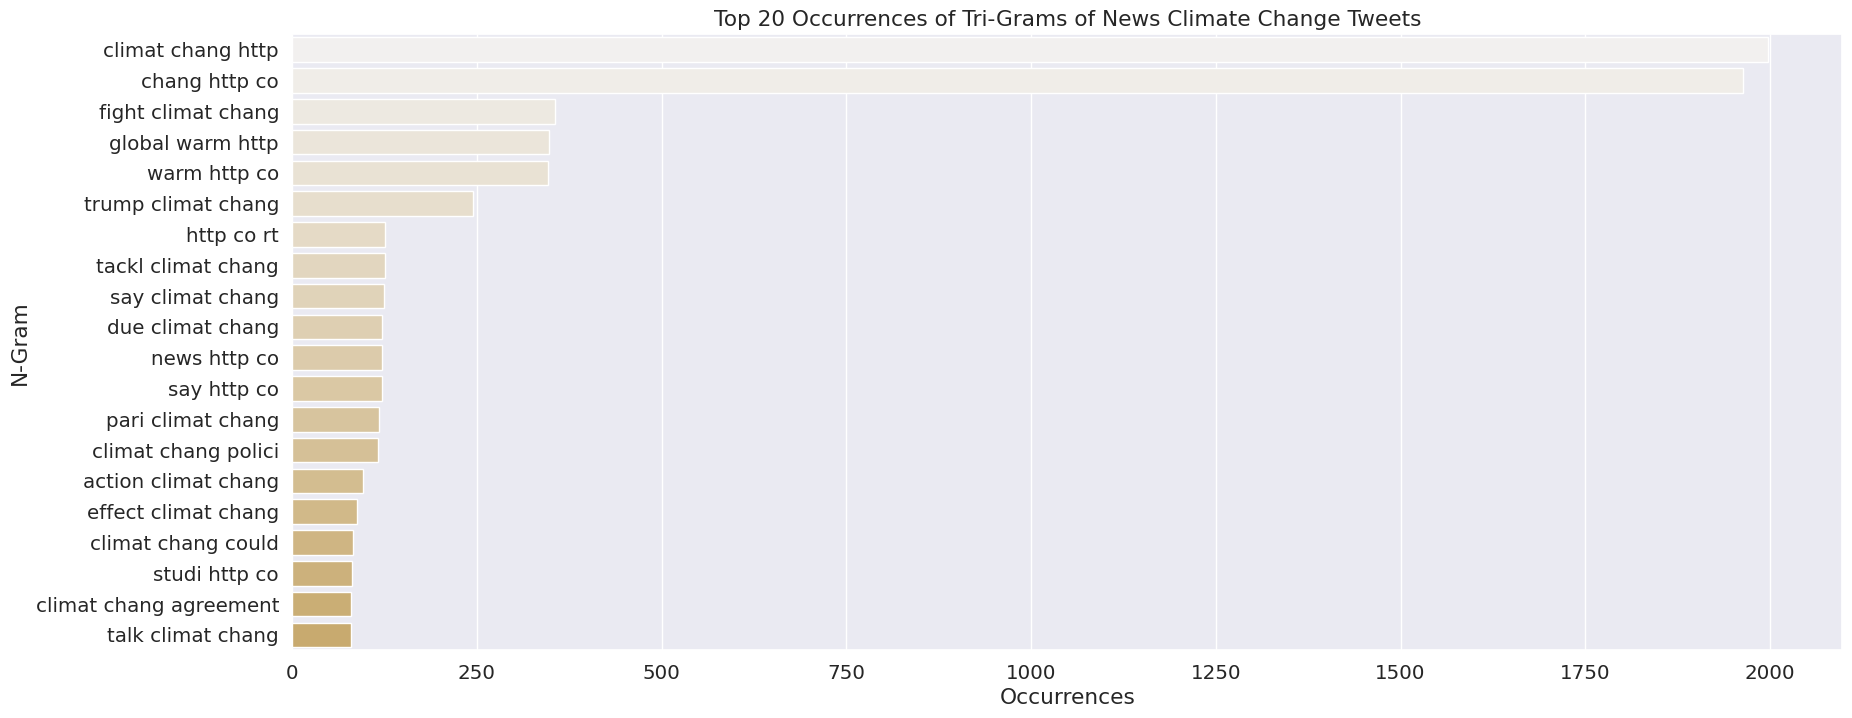

In [ ]:
counterDfNews = generateWordList(dfSub, 2, SIZE)
counterDfNewsTop = counterDfNews.head(20)
print(counterDfNewsTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of News Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNewsTop, palette="light:#D7AF60")

Model Development

Various models will be built to predict the sentiment of tweets pertaining to climate change.

In [ ]:
def evaluateModel(model, X_test, y_test, title):
    '''
    print out classification scores
    :param model: used model
    :param X_test:
    :param y_test:
    :param title: title of the model
    '''
    print("\n*** " + title + " ***")
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions, average='weighted')
    precision = metrics.precision_score(y_test, predictions, average='weighted')
    f1 = metrics.f1_score(y_test, predictions, average='weighted')

    clsScoreDict = {
        "accuracy": accuracy
        , "recall": recall
        , "precision": precision
        , "f1": f1
    }

    print("Accuracy:  " + str(accuracy))
    print("Precision: " + str(precision))
    print("Recall:    " + str(recall))
    print("F1:        " + str(f1))
    print("\n\n")

    return clsScoreDict

In [ ]:
def modelAndPredict(X, target, model):
    '''
    Build model and predict scores.

    :param X: X contains the stemmed and vectorized sentences.
    :param target: the sentiment rating
    :param model: selected model
    :return: X_test, y_test, and y_predicted values.
    '''

    modelType = model.__class__.__name__

    # Create training set with 75% of data and test set with 25% of data.
    X_train, X_test, y_train, y_test = train_test_split(
        X, target, train_size=0.75
    )

    # Build the model with the training data.
    clfModel = model.fit(X_train, y_train)
    clsScoreDict = evaluateModel(clfModel, X_test, y_test, modelType)


    # Predict target values.
    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict

In [ ]:
def showFormattedConfusionMatrix(y_test, y_predicted):
    '''
    Draw the confusion matrix.
    :param y_test
    :param y_predicted
    :return:
    '''
    # print a simple confusion matrix
    cm = metrics.confusion_matrix(y_test.values, y_predicted)
    print(cm)

    # Show confusion matrix with colored background.
    Index = ['Actual -1', 'Actual 0', 'Actual 1', 'Actual 2', ]
    Cols = ['Pred -1', 'Pred 0', 'Pred 1', 'Pred 2']
    df = pd.DataFrame(cm, index=Index, columns=Cols)
    plt.figure(figsize=(4, 4))

    ax = sns.heatmap(df, cmap='Blues', annot=True, fmt='g')
    bottom, top = ax.get_ylim()
    ax.set(title="Movie Review Sentiment")
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30,
                       horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0,
                       horizontalalignment='right')


In [ ]:
# bi-gram vectorization
NGRAM_RANGE_START = 2
NGRAM_RANGE_END = 2

vectorizedTweets2, vectorDictionary2 = vectorizeList(stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END)

In [ ]:
# tri-gram vectorization
NGRAM_RANGE_START = 3
NGRAM_RANGE_END = 3

vectorizedTweets3, vectorDictionary3 = vectorizeList(stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END)

In [ ]:
# bi-gram & tri-gram vectorization
NGRAM_RANGE_START = 2
NGRAM_RANGE_END = 3

vectorizedTweets23, vectorDictionary23 = vectorizeList(stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END)

1. Logistic Regression

In [ ]:
model = LogisticRegression()

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



*** LogisticRegression ***
Accuracy:  0.7345712725286728
Precision: 0.7286600711637211
Recall:    0.7345712725286728
F1:        0.7281294661126299



[[ 545  174  268   36]
 [  94  945  762  119]
 [  91  377 4829  406]
 [  20   83  486 1751]]


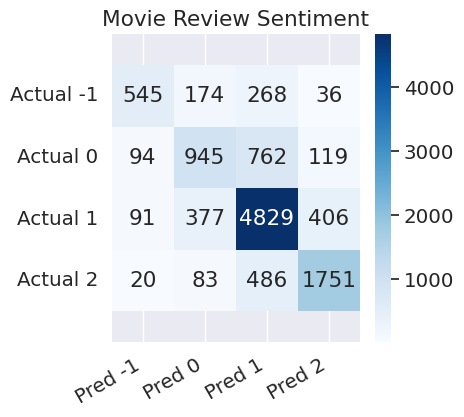

In [ ]:
X_test, y_test, y_predicted, lrScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

Bi-Gram Logistic Regression

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



*** LogisticRegression ***
Accuracy:  0.697524121609321
Precision: 0.6977255163725103
Recall:    0.697524121609321
F1:        0.6799506740901454



[[ 325  194  443   32]
 [  36  756 1024  110]
 [  30  360 5066  312]
 [  14   56  712 1516]]


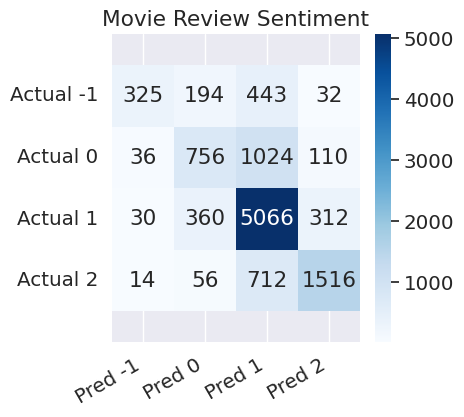

In [ ]:
X_test, y_test, y_predicted, lrScoreDict2 = modelAndPredict(vectorizedTweets2, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

Tri-gram Logistic Regression

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



*** LogisticRegression ***
Accuracy:  0.6603859457491352
Precision: 0.6657815851552356
Recall:    0.6603859457491352
F1:        0.627354380453713



[[ 233  123  586   39]
 [  21  488 1288   93]
 [  26  226 5164  308]
 [  16   58  947 1370]]


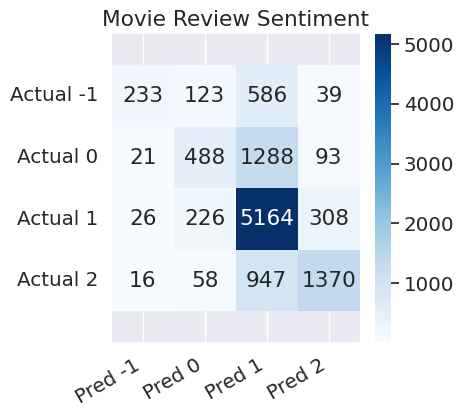

In [ ]:
X_test, y_test, y_predicted, lrScoreDict3 = modelAndPredict(vectorizedTweets3, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

Bi-Gram & Tri-Gram Logistic Regression

In [ ]:
X_test, y_test, y_predicted, lrScoreDict23 = modelAndPredict(vectorizedTweets23, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

N-gram Comparisons

We have built different vectorized sentences using different ranges of N-grams (1, 2, 3, and 2 to 3). Each of them was fed to a logistic regression model and evaluated based on classification scores such as accuracy, precision, recall and F1. In this section, we will compare all the scores and see what N-gram has worked the best.

In [ ]:
lsScoreDf = pd.DataFrame(lrScoreDict, index=["-"])
lsScoreDf2 = pd.DataFrame(lrScoreDict2, index=["Bi-gram"])
lsScoreDf3 = pd.DataFrame(lrScoreDict3, index=["Tri-gram"])
lsScoreDf23 = pd.DataFrame(lrScoreDict23, index=["Bi-gram and Tri-gram"])

lsScoreComparisonDf = pd.concat([lsScoreDf, lsScoreDf2, lsScoreDf3, lsScoreDf23])
lsScoreComparisonDf

2. Decision Tree

In [ ]:
model = DecisionTreeClassifier(max_depth=20)

In [ ]:
X_test, y_test, y_predicted, treeScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

3. Random Forest Classifier

In [ ]:
model = RandomForestClassifier()


*** RandomForestClassifier ***
Accuracy:  0.7044420171126888
Precision: 0.7120479411203667
Recall:    0.7044420171126888
F1:        0.6849961503761011



[[ 281  188  489   53]
 [  33  864  979   86]
 [  24  294 5080  271]
 [   4   47  779 1514]]


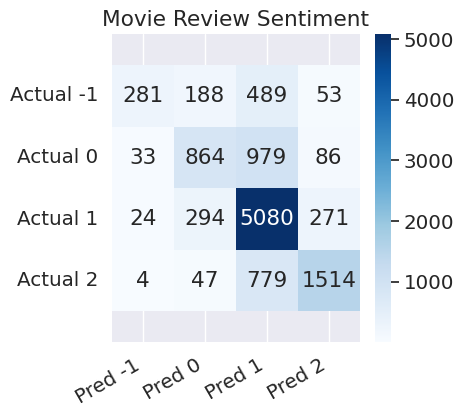

In [ ]:
X_test, y_test, y_predicted, rfScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

4. Extra Trees Classifier

In [ ]:
model = ExtraTreesClassifier()


*** ExtraTreesClassifier ***
Accuracy:  0.7079009648643728
Precision: 0.7090239657491451
Recall:    0.7079009648643728
F1:        0.6906709734051021



[[ 286  191  435   50]
 [  36  838  961  102]
 [  27  345 5062  305]
 [  12   42  703 1591]]


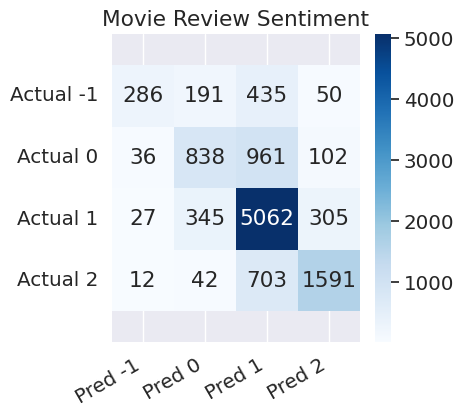

In [ ]:
X_test, y_test, y_predicted, xtreeScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

5. K Neighbors Classifier

In [ ]:
model = KNeighborsClassifier()


*** KNeighborsClassifier ***
Accuracy:  0.3927726196977972
Precision: 0.6952743792578959
Recall:    0.3927726196977972
F1:        0.40422701932094907



[[ 125  781   64    7]
 [  22 1777  110   19]
 [  39 3952 1646  122]
 [  15 1320  220  767]]


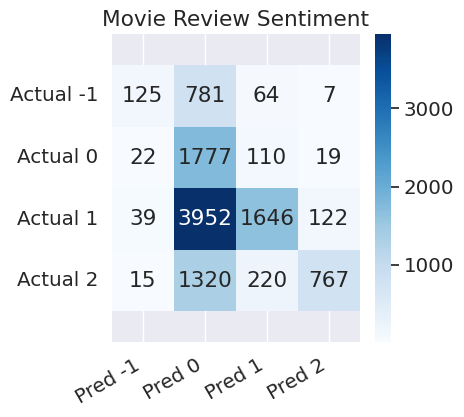

In [ ]:
X_test, y_test, y_predicted, knnScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

6. Linear Support Vector Classifier (SVC)

In [ ]:
model = SVC()


*** SVC ***
Accuracy:  0.7301110504278172
Precision: 0.7330925677701913
Recall:    0.7301110504278172
F1:        0.7143095574942246



[[ 414  147  405   50]
 [  38  792  962  111]
 [  30  214 5118  323]
 [  16   35  634 1697]]


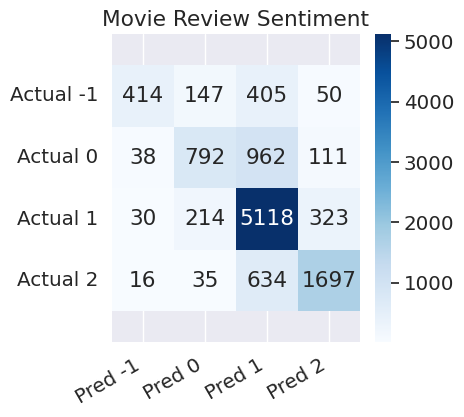

In [ ]:
X_test, y_test, y_predicted, svcScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

7. Ridge Classifier

In [ ]:
model = RidgeClassifier()


*** RidgeClassifier ***
Accuracy:  0.7193701074094302
Precision: 0.7125812626300616
Recall:    0.7193701074094302
F1:        0.712728124472916



[[ 504  168  245   54]
 [ 110  890  759  144]
 [  76  427 4813  436]
 [  18   88  558 1696]]


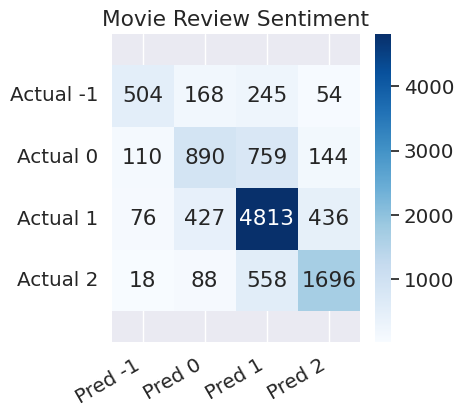

In [ ]:
X_test, y_test, y_predicted, ridgeScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

Model Comparisons

In [ ]:
lrScoreDf = pd.DataFrame(lrScoreDict, index=["Logistic Regression"])
treeScoreDf = pd.DataFrame(treeScoreDict, index=["Decision Tree"])
rfScoreDf = pd.DataFrame(rfScoreDict, index=["Random Forest Classification"])
xtreeScoreDf = pd.DataFrame(xtreeScoreDict, index=["Extra Trees Classification"])
knnScoreDf = pd.DataFrame(knnScoreDict, index=["K Neighbors Classification"])
svcScoreDf = pd.DataFrame(svcScoreDict, index=["Linear Support Vector Classifier Classification"])
ridgeScoreDf = pd.DataFrame(ridgeScoreDict, index=["Ridge Classification"])

clsCompDf = pd.concat([lrScoreDf, treeScoreDf, rfScoreDf, xtreeScoreDf, knnScoreDf, svcScoreDf, ridgeScoreDf])

clsCompDf.sort_values(by=["accuracy", "f1"], ascending = False)

,accuracy,recall,precision,f1
Logistic Regression,0.733752,0.733752,0.727292,0.725761
Linear Support Vector Classifier Classification,0.730111,0.730111,0.733093,0.714310
Ridge Classification,0.719370,0.719370,0.712581,0.712728
Extra Trees Classification,0.707901,0.707901,0.709024,0.690671
Random Forest Classification,0.704442,0.704442,0.712048,0.684996
Decision Tree,0.607045,0.607045,0.619258,0.558153
K Neighbors Classification,0.392773,0.392773,0.695274,0.404227


Binary File Export

To reuse the built model to predict other tweets, we will be saving the model as a binary file.

In [ ]:
def modelAndPredict(X, target, model):
    '''
    Build model and predict scores.

    :param X: X contains the stemmed and vectorized sentences.
    :param target: the sentiment rating
    :param model: selected model
    :return: X_test, y_test, and y_predicted values.
    '''

    modelType = model.__class__.__name__

    # Create training set with 75% of data and test set with 25% of data.
    X_train, X_test, y_train, y_test = train_test_split(
        X, target, train_size=0.75
    )

    # Build the model with the training data.
    clfModel = model.fit(X_train, y_train)

    # save model to a pickle file
    # create directory for models
    if (not path.exists("./model")):
        makedirs('./model')
    pickle.dump(clfModel, open(f"./model/climate_change_tweet_sentiment_{modelType}.dat", "wb"))

    # load model
    loadedModel = pickle.load(open(f"./model/climate_change_tweet_sentiment_{modelType}.dat", "rb"))

    clsScoreDict = evaluateModel(loadedModel, X_test, y_test, modelType)


    # Predict target values.
    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict

In [ ]:
model = LogisticRegression()

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



*** LogisticRegression ***
Accuracy:  0.7376661205170216
Precision: 0.7326430841538322
Recall:    0.7376661205170216
F1:        0.7313941617206727



[[ 534  199  255   59]
 [  78  971  710  143]
 [  84  396 4870  353]
 [  24   75  506 1729]]


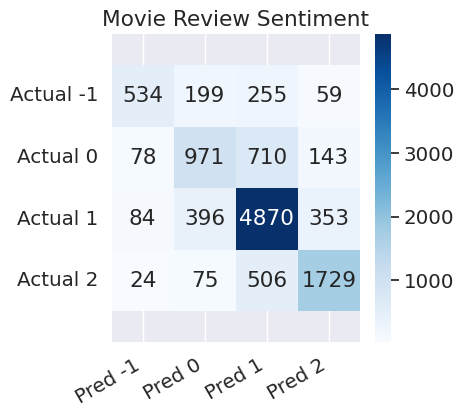

In [ ]:
X_test, y_test, y_predicted, lrScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

We also need a reference to vectors for each word found in the dataset. The word dictionary will be exported as a JSON file. Each unique word in the dataset is associated with its vector value.

In [ ]:
with open("wordDictionary.json", "w") as fp:
    json.dump(vectorDictionary, fp)